In [1]:
%load_ext jupyter_black

In [2]:
import pickle
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from collections import namedtuple
from typing import Iterable, Literal
from copy import deepcopy
import re

In [3]:
import warnings
import sys
import os

In [4]:
from collections import namedtuple

In [5]:
project = "x-avenue-450615-c3"
dataset_name = "jobs_postings"
location = "europe-west1"

bq_client = bigquery.Client()

In [6]:
CURRENT_DIRECTORY = os.getcwd()
PROJECT_ROOT = os.path.abspath(
    os.path.join(CURRENT_DIRECTORY, "../pipelines/rapidapi_jobs_posting/")
)
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"{PROJECT_ROOT} was added to sys.path")

REPO_ROOT = os.path.abspath(os.path.join(CURRENT_DIRECTORY, ".."))
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)
    print(f"{REPO_ROOT} was added to sys.path")

/home/jovyan/work/repos/jobs-research/pipelines/rapidapi_jobs_posting was added to sys.path
/home/jovyan/work/repos/jobs-research was added to sys.path


In [7]:
from common.utils import bq_table_to_df

In [8]:
sheet_url = "https://docs.google.com/spreadsheets/d/1clAiWIVMD5bCJRHJr9-p2vw9h99W5sByAtqThIGREpo/edit?gid=0#gid=0"
csv_export_url = sheet_url.replace("/edit?gid=", "/export?format=csv&gid=")

In [9]:
csv_export_url

'https://docs.google.com/spreadsheets/d/1clAiWIVMD5bCJRHJr9-p2vw9h99W5sByAtqThIGREpo/export?format=csv&gid=0#gid=0'

In [10]:
rules_df = pd.read_csv(csv_export_url)

In [11]:
rules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   keyword           94 non-null     object
 1   result            176 non-null    object
 2   case_sensitive    176 non-null    bool  
 3   spaces_sensitive  176 non-null    bool  
dtypes: bool(2), object(2)
memory usage: 3.2+ KB


In [12]:
REPLACE_WITH_SPACES = r"[!\"$\%'()\+,\-./:;?]"


def prepare_text(
    text: str,
    case_sensitive: bool,
    spaces_sensitive: bool,
    replace_with_spaces=REPLACE_WITH_SPACES,
) -> str:
    """Normalize text for keywords search"""
    if not case_sensitive:
        text = text.lower()
    if not spaces_sensitive:
        text = text.replace(" ", "")
    else:

        text = re.sub(replace_with_spaces, " ", text)
        text = " " + text.strip() + " "
    return text

In [75]:
class _MappingDict:
    """
    Internal helper class used by MappingRules to store normalized keyword mappings.
    This class is not intended for direct use.

    Attributes:
        rules (dict): A mapping of keywords to values.
        case_sensitive (bool): Whether keyword search is case-sensitive.
        spaces_sensitive (bool): Whether keyword search should preserve spaces and special characters.
        is_prepared (bool): Whether rules are already normalized.

    Methods:
        prepare():
            Normalizes all keywords in the mapping according to the case and space sensitivity rules.
    """

    def __init__(
        self,
        rules: dict,
        case_sensitive: bool = False,
        spaces_sensitive: bool = False,
    ):
        self.rules = rules
        self.case_sensitive = case_sensitive
        self.spaces_sensitive = spaces_sensitive
        self.is_prepared = False

    def prepare(self):
        if not self.is_prepared:
            prepared_rules = {}
            for key, val in self.rules.items():
                prepared_key = prepare_text(
                    key, self.case_sensitive, self.spaces_sensitive
                )
                prepared_rules[prepared_key] = val
                for char in REPLACE_WITH_SPACES:
                    if self.spaces_sensitive and prepared_key != key and char in key:
                        warnings.warn(
                            f"'{char}' in the keyword '{key}' was replaced with a space.",
                            UserWarning,
                        )
            self.rules = prepared_rules
            self.is_prepared = True
        else:
            warnings.warn("MappingDict is already prepared.", UserWarning)
        return self

In [76]:
?_MappingDict

Init signature:
_MappingDict(
    rules: dict,
    case_sensitive: bool = False,
    spaces_sensitive: bool = False,
)
Docstring:     
Internal helper class used by MappingRules to store normalized keyword mappings.
This class is not intended for direct use.

Attributes:
    rules (dict): A mapping of keywords to values.
    case_sensitive (bool): Whether keyword search is case-sensitive.
    spaces_sensitive (bool): Whether keyword search should preserve spaces and special characters.
    is_prepared (bool): Whether rules are already normalized.

Methods:
    prepare():
        Normalizes all keywords in the mapping according to the case and space sensitivity rules.
Type:           type
Subclasses:     

In [77]:
class MappingRules:
    """
    Handles keyword-based mapping rules with configurable text normalization.

    This class is responsible for validating, preparing, and applying mapping rules
    defined in a pandas DataFrame. Each rule maps a keyword to a result value,
    optionally specifying case and space sensitivity. The rules are grouped
    by normalization settings and transformed into MappingDicts for fast lookup.

    Attributes:
        attr_name (str): The name of the attribute the rules apply to (used for error messages).
        rules_df (pd.DataFrame): DataFrame containing the rules, must have columns:
            ["keyword", "result", "case_sensitive", "spaces_sensitive"].
        _is_prepared (bool): Indicates whether the rules have been processed into MappingDicts.

    Methods:
        prepare():
            Groups and transforms the rules into MappingDicts according to their normalization settings.
        apply(texts, find):
            Applies the mapping to a list of texts, returning either the first match ("any")
            or a set of all matches ("all").
    """

    def __init__(self, attr_name: str, rules_df: pd.DataFrame):
        self.attr_name = attr_name
        self.rules_df = rules_df[
            ["keyword", "result", "case_sensitive", "spaces_sensitive"]
        ]

        self._check_for_nulls()
        self.rules_df["keyword"] = self.rules_df.apply(
            lambda x: x.result if pd.isna(x.keyword) else x.keyword, axis="columns"
        )
        self._check_keywords_uniqueness()
        self._is_prepared = False

    def _check_for_nulls(self):
        for col in ["result", "case_sensitive", "spaces_sensitive"]:
            if rules_df[col].isna().sum() > 0:
                raise ValueError(
                    f"'{col}' can not be Null. Fix mapping rules for {self.attr_name}."
                )

    def _check_keywords_uniqueness(self):
        non_unique_keywords = self.rules_df["keyword"].value_counts()[lambda x: x > 1]
        if len(non_unique_keywords) > 0:
            non_unique_keywords_str = ", ".join(non_unique_keywords.index)
            raise ValueError(
                f"Keywords must be unique. Fix mapping rules for {self.attr_name}: {non_unique_keywords_str}."
            )

    def prepare(self):
        if not self._is_prepared:
            self.map_dicts = list(
                self.rules_df.set_index("keyword")
                .groupby(by=["case_sensitive", "spaces_sensitive"])
                .agg(dict)
                .rename({"result": "mapping_dict"}, axis="columns")
                .reset_index()
                .apply(
                    lambda x: MappingDict(
                        rules=x.mapping_dict,
                        case_sensitive=x.case_sensitive,
                        spaces_sensitive=x.spaces_sensitive,
                    ),
                    axis="columns",
                )
            )
            self.map_dicts_prepared = [
                mapping_dict.prepare() for mapping_dict in self.map_dicts
            ]
            self._is_prepared = True
        else:
            warnings.warn("MappingRules are already prepared.", UserWarning)

    def apply(
        self, texts: Iterable[str], find: Literal["any", "all"] = "all"
    ) -> str | set[str] | None:

        if not self._is_prepared:
            self.prepare()

        if find == "all":
            result = set()
        if find == "any":
            result = None

        for mapping_dict in self.map_dicts_prepared:
            for text in texts:
                text = prepare_text(
                    text, mapping_dict.case_sensitive, mapping_dict.spaces_sensitive
                )
                for key, val in mapping_dict.rules.items():
                    if key in text:
                        if find == "all":
                            result.add(val)
                        if find == "any":
                            return val
        return result

In [15]:
skills_rules = MappingRules("skills", rules_df)

In [16]:
skills_rules.apply(["BI"], "all")

{'BI'}

In [17]:
skills_rules.apply([" BI "], "all")

{'BI'}

In [18]:
skills_rules.apply(["hI BI!"], "all")

{'BI'}

In [19]:
skills_rules.apply([" bi "], "all")

set()

In [20]:
skills_rules.apply([" BINGO!"], "all")

set()

In [21]:
skills_rules.apply(["BigQuery"], "all")

{'Google BigQuery'}

In [22]:
skills_rules.apply(["(BigQuery)"], "all")

{'Google BigQuery'}

In [23]:
skills_rules.apply(["(Big Query)"], "all")

{'Google BigQuery'}

In [24]:
skills_rules.apply(["(JavaScRiPt "], "all")

{'JavaScript'}

In [78]:
skills_rules.apply(["(Java ScRiPt "], "all")

{'Java'}

In [26]:
skills_rules.apply(["piu-piu(bigquery/Hive/CosmosDB)"], "all")

{'Azure Cosmos', 'Google BigQuery', 'Hive'}

In [27]:
df_posting_load_query = f"""
select *
from `x-avenue-450615-c3.jp.jobs` as jp
where position = 'Data Engineer'
"""
df_posting = bq_client.query(df_posting_load_query).to_dataframe()

In [28]:
df_posting["skills"] = df_posting["description"].map(
    lambda x: set() if pd.isna(x) else skills_rules.apply([x])
)

In [29]:
df_posting.position.value_counts()

position
Data Engineer    880
Name: count, dtype: int64

In [30]:
[
    print(x[1].skills, "\n" * 2, x[1].description, "\n" * 5)
    for x in (
        df_posting[df_posting.position == "Data Engineer"][["skills", "description"]]
        .sample(10)
        .iterrows()
    )
]
_

{'Agile', 'Cloud'} 

 **Join our global team of experts** At diconium, you will work on projects that create value from software, data, and AI, enabling businesses to achieve more with less. You will collaborate with over 2,300 fellow experts to support global leading companies in maximizing the impact of digital efforts and delivering solutions with measurable business impact. We prioritize people and genuine human connection, ensuring a supportive and inclusive work environment. And we give you maximum flexibility thanks to our hybrid workplace.  

**What You Can Expect**

* You lead an international, multifunctional Data Engineering \& Data Architecture team within the diconium data unit, driving complex digital business solutions.
* Your primary focus is strategic leadership. You have both the responsibility and the freedom to shape the success of the Data Engineering \& Data Architecture department.
* Beyond leading your team, you also oversee project and account management, ensur

position
Data Engineer    880
Name: count, dtype: int64

In [31]:
skills_set = rules_df.result.unique()

cloud_skills_sets = dict()

cloud_skills_sets["Google Cloud Platform"] = {x for x in skills_set if "Google" in x}
cloud_skills_sets["Microsoft Azure"] = {x for x in skills_set if "Azure" in x}
cloud_skills_sets["Amazon Web Services"] = {x for x in skills_set if "Amazon" in x}

cloud_skills_sets

{'Google Cloud Platform': {'Google BigQuery',
  'Google Bigtable',
  'Google Cloud Apache Beam',
  'Google Cloud Composer',
  'Google Cloud Dataflow',
  'Google Cloud Functions',
  'Google Cloud Platform',
  'Google Cloud Run',
  'Google Cloud Scheduler',
  'Google Data Catalog',
  'Google Dataplec',
  'Google Dataproc',
  'Google Gloud Pub/Sub',
  'Google Looker Studio',
  'Google Spanner',
  'Google Storage',
  'Google Vertex AI'},
 'Microsoft Azure': {'Azure Blob Storage',
  'Azure Cosmos',
  'Azure Data Factory',
  'Azure Data Lake Storage ',
  'Azure Event Grid',
  'Azure Event Hubs',
  'Azure Function',
  'Azure Functions',
  'Azure HDInsight',
  'Azure Machine Learning',
  'Azure Stream Analytics',
  'Azure Synapse',
  'Azure/Microsoft Purview',
  'Microsoft Azure'},
 'Amazon Web Services': {'Amazon Athena',
  'Amazon Elastic Compute Cloud (EC2)',
  'Amazon Elastic MapReduce',
  'Amazon EventBridge',
  'Amazon Fargate',
  'Amazon Firehose',
  'Amazon Glue',
  'Amazon Kinesis',
 

In [32]:
for cloud, skills_set in cloud_skills_sets.items():
    df_posting["skills"] = df_posting["skills"].map(
        lambda x: x | {cloud} if x & skills_set else x
    )

In [33]:
clouds_set = set(cloud_skills_sets.keys())
clouds_set

{'Amazon Web Services', 'Google Cloud Platform', 'Microsoft Azure'}

In [34]:
df_posting["skills"] = df_posting["skills"].map(
    lambda x: x | {"Cloud"} if x & clouds_set else x
)

In [35]:
count_has_skills = (df_posting["skills"] != set()).sum()
count_all = df_posting["skills"].count()
print("skills defined for", "{:.0%}".format(count_has_skills / count_all), "jobs")
print((count_all - count_has_skills), "jobs doesn`t have skills")

skills defined for 98% jobs
14 jobs doesn`t have skills


In [36]:
df_posting[df_posting["skills"] == set()]["description"].map(print)
_

Data Engineer / Data Scientist (m/f/d) Bachelor of Science Computer Science  

For Our Information Technology IT Department At Our Head Office In Stuttgart Or At Our Waterworks In Langenau, We Are Looking For You With Immediate Effect As  

Data Engineer / Data Scientist (m/f/d)  

Bachelor of Science Computer Science  

Your tasks  

* Planning, operating and monitoring the databases of our digital data acquisition system
* Creation of database queries and evaluation algorithms (e.g. application of modules for multivariate statistics and artificial intelligence)
* Collaboration with external service providers in the field of data science
* Data migration of legacy data
* Collaboration in IT projects in the area of digitization of business processes   

Your profile  

* Degree in computer science and at least 2 years of professional experience in database management / data science / big data or comparable training in the IT field as well as several years of relevant professional exper

{'Amazon Web Services', 'Google Cloud Platform', 'Microsoft Azure'}

In [37]:
df_skills = df_posting[["id", "position", "skills"]].explode("skills").dropna()

In [38]:
df_skills.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8952 entries, 0 to 879
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8952 non-null   object
 1   position  8952 non-null   object
 2   skills    8952 non-null   object
dtypes: object(3)
memory usage: 279.8+ KB


In [39]:
df_skills.skills.value_counts().head(15)

skills
Cloud                    740
Python                   715
SQL                      633
Amazon Web Services      407
Google Cloud Platform    369
Microsoft Excel          360
Microsoft Azure          339
Spark                    279
Google Dataproc          270
Airflow                  236
Agile                    208
Databricks               199
BI                       192
Apache Kafka             178
Snowflake                175
Name: count, dtype: int64

In [40]:
pd.options.display.float_format = "{:.0%}".format

In [41]:
skills_value_counts = df_skills.skills.value_counts()
skills_value_counts.head(25) / len(df_posting)

skills
Cloud                   84%
Python                  81%
SQL                     72%
Amazon Web Services     46%
Google Cloud Platform   42%
Microsoft Excel         41%
Microsoft Azure         39%
Spark                   32%
Google Dataproc         31%
Airflow                 27%
Agile                   24%
Databricks              23%
BI                      22%
Apache Kafka            20%
Snowflake               20%
Terraform               18%
Orchestration           16%
Docker                  16%
ML                      15%
Kubernetes              14%
Streaming               14%
Java                    14%
Google BigQuery         14%
PostgreSQL              13%
Batch processing        11%
Name: count, dtype: float64

In [42]:
len(df_skills.skills.unique())

119

In [43]:
skills_value_counts.tail(10)

skills
Google Vertex AI           2
DLT                        1
UC                         1
Columnar DBMS              1
Google Cloud Composer      1
SISTRA                     1
Power Query                1
Impala                     1
Azure/Microsoft Purview    1
XGBoost                    1
Name: count, dtype: int64

In [44]:
sum(skills_value_counts / len(df_posting) >= 0.05)

43

In [45]:
from functools import reduce

all_cloud_skills_set = reduce(lambda x, y: x | y, cloud_skills_sets.values())
all_cloud_skills_set

{'Amazon Athena',
 'Amazon Elastic Compute Cloud (EC2)',
 'Amazon Elastic MapReduce',
 'Amazon EventBridge',
 'Amazon Fargate',
 'Amazon Firehose',
 'Amazon Glue',
 'Amazon Kinesis',
 'Amazon Lake Formation',
 'Amazon Lambda',
 'Amazon Managed Streaming',
 'Amazon Managed Workflows for Apache Airflow',
 'Amazon QuickSight',
 'Amazon Redshift',
 'Amazon Relational Database Service (RDS)',
 'Amazon S3',
 'Amazon SageMaker',
 'Amazon Step Functions',
 'Amazon Web Services',
 'Azure Blob Storage',
 'Azure Cosmos',
 'Azure Data Factory',
 'Azure Data Lake Storage ',
 'Azure Event Grid',
 'Azure Event Hubs',
 'Azure Function',
 'Azure Functions',
 'Azure HDInsight',
 'Azure Machine Learning',
 'Azure Stream Analytics',
 'Azure Synapse',
 'Azure/Microsoft Purview',
 'Google BigQuery',
 'Google Bigtable',
 'Google Cloud Apache Beam',
 'Google Cloud Composer',
 'Google Cloud Dataflow',
 'Google Cloud Functions',
 'Google Cloud Platform',
 'Google Cloud Run',
 'Google Cloud Scheduler',
 'Google 

<Axes: ylabel='skills'>

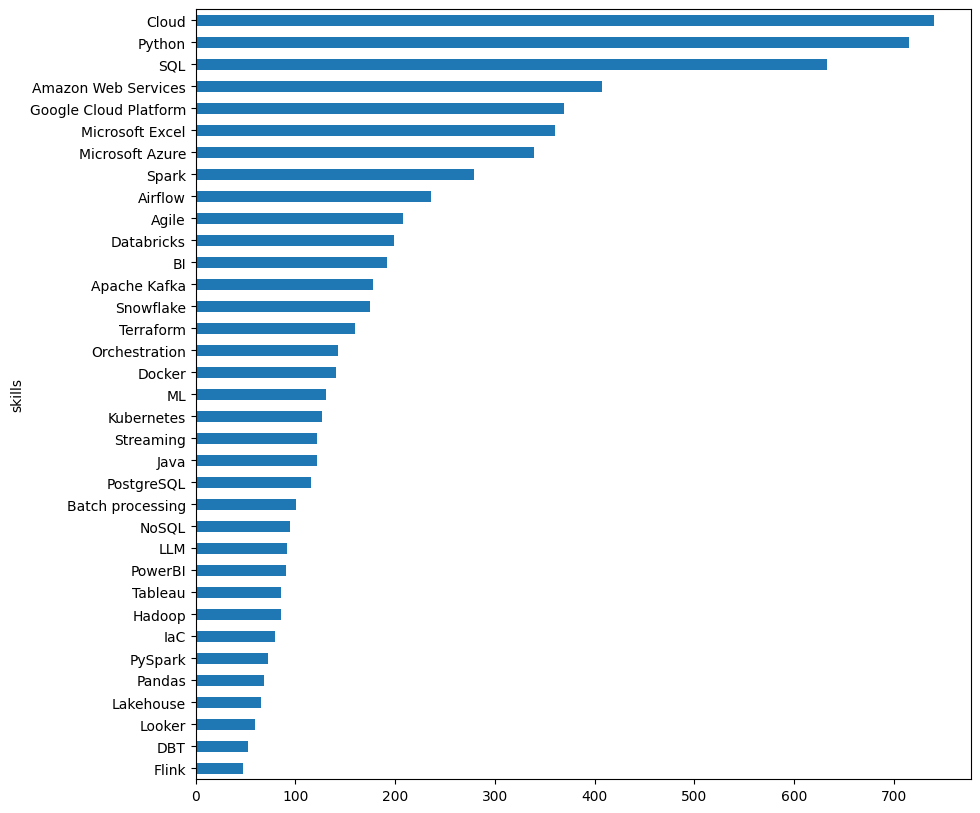

In [46]:
import matplotlib.pyplot as plt

skills_value_counts[
    (skills_value_counts / len(df_posting) >= 0.05)
    & (
        skills_value_counts.index.map(
            lambda x: x not in all_cloud_skills_set - clouds_set
        )
    )
].sort_values().plot(kind="barh", figsize=(10, 10))

<Axes: ylabel='skills'>

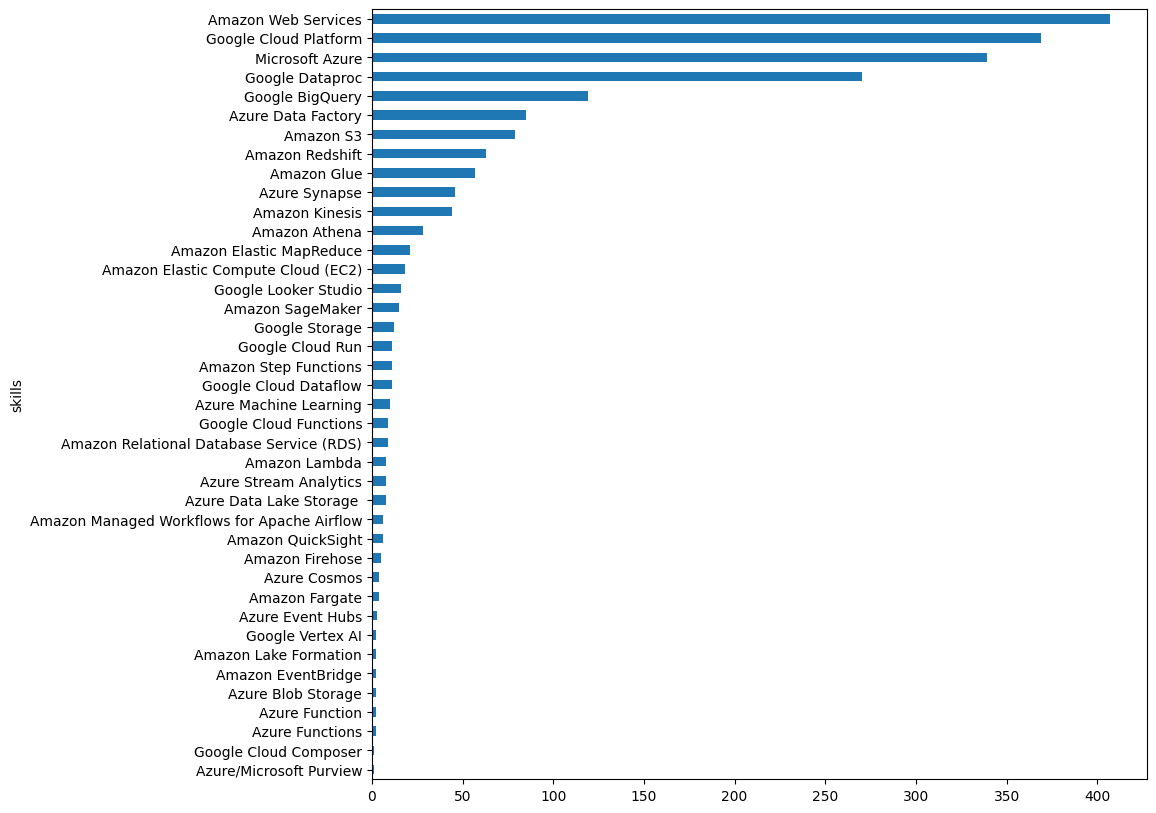

In [47]:
skills_value_counts[
    (skills_value_counts.index.map(lambda x: x in all_cloud_skills_set))
].sort_values().plot(kind="barh", figsize=(10, 10))

In [48]:
from common.utils import df_to_bq

df_to_bq(df_skills, "jobs_skills", "jp_test", project, bq_client=None, truncate=False)

Loaded 8952 rows to x-avenue-450615-c3.jp_test.jobs_skills


In [49]:
df_to_bq(
    df_posting,
    "tmp_jobs_with_skills",
    "jp_test",
    project,
    bq_client=None,
    truncate=False,
)

Loaded 880 rows to x-avenue-450615-c3.jp_test.tmp_jobs_with_skills
